In [64]:
using Plots
include("coevolution_network_base.jl")
using .CoevolutionNetworkBase
using DifferentialEquations

In [124]:
# Parameters
L = 60.0
dx = 0.25
x = -L/2:dx:L/2-dx
r = 3.3
M = 15
beta = 2.5
alpha = 1.0
gamma = 0.0
D = 0.001
Nh = 3 * 10^6

# Initialize viral and immune densities
viral_density = zeros(Float64, length(x))
viral_density[Int(length(x)/2)] = 10/dx
# viral_density2 = zeros(Float64, length(x))
immune_density = zeros(Float64, length(x))

# Create Population instances
population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=false)
# population2 = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density2, immune_density)

# Create Network instance
migration_matrix = [0.0][:,:] # Define an appropriate migration matrix
network = Network([population], migration_matrix)

# Create Simulation instance
dt = 0.05 # Define an appropriate time step size
duration = 80.0 # Define an appropriate simulation duration
simulation = Simulation(network, dt, duration)

# Run the simulation
@time run_simulation!(simulation)


  1.561120 seconds


true

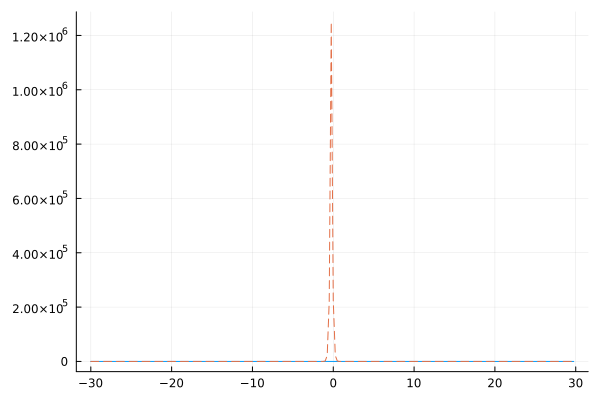

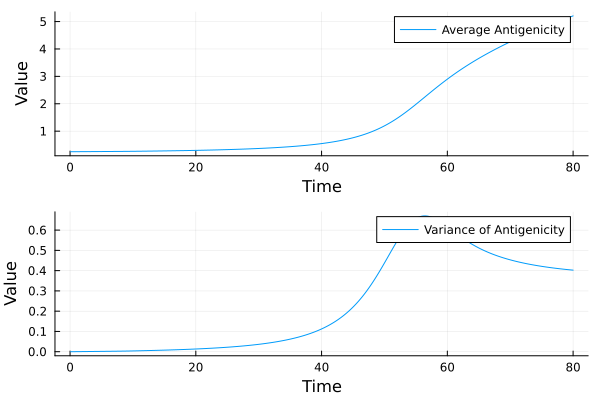

In [127]:
p = plot()
reg = population.xs .> 0
for i = length(simulation.duration_times)
    plot!(p, population.xs, simulation.trajectory[i].populations[1].viral_density,legend=false)
end
plot!(p, population.xs, Nh .* simulation.trajectory[end].populations[1].immune_density, legend=false, linestyle=:dash)
display(p)

# Assuming the relevant data structures are present
num_timepoints = length(simulation.duration_times)
avg_antigenicity = Vector{Float64}(undef, num_timepoints)
variance_antigenicity = Vector{Float64}(undef, num_timepoints)

for i = 1:num_timepoints
    viral_densities = simulation.trajectory[i].populations[1].viral_density
    total_density = sum(viral_densities[reg])
    
    # Average antigenicity for the current time point
    avg_antigenicity[i] = sum(population.xs[reg] .* viral_densities[reg]) / total_density
    
    # Variance calculation for the current time point
    deviations = population.xs[reg] .- avg_antigenicity[i]
    variance_antigenicity[i] = sum((deviations .^ 2) .* viral_densities[reg]) / total_density
end

# Plotting the average and variance over time
using Plots

p1 = plot(simulation.duration_times, avg_antigenicity, label="Average Antigenicity", xlabel="Time", ylabel="Value", legend=:topright)
p2 = plot(simulation.duration_times, variance_antigenicity, label="Variance of Antigenicity", xlabel="Time", ylabel="Value", legend=:topright)

plot(p1, p2, layout=(2,1))


Found S_f: 0.10735573418267548
Found H_f: 0.13823599567535516


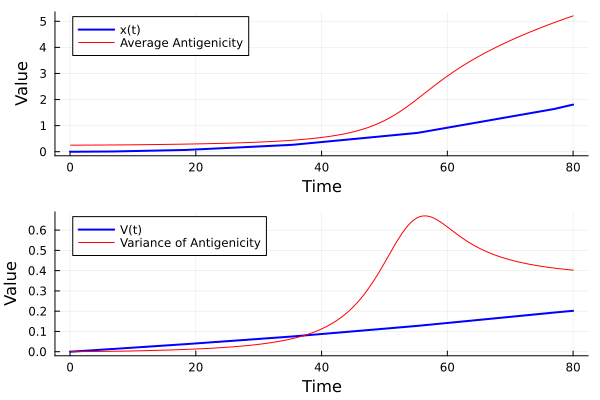

In [126]:

# Given parameter R_0
R_0 = beta/(alpha + gamma)  # Change this to your actual R_0

# Define the function for the iteration
function next_S(S)
    return exp(-R_0 * (1-S))
end

# Fixed-point iteration to find S_f
Sf_initial_guess = 0.5
S_previous = Sf_initial_guess
tolerance = 1e-6
max_iterations = 1000
iteration = 0

while iteration < max_iterations
    S_next = next_S(S_previous)
    
    # Break if the change is below the tolerance
    if abs(S_next - S_previous) < tolerance
        break
    end
    
    S_previous = S_next
    iteration += 1
end

S_f = S_previous
H_f = 1 - S_f^(1/M)

println("Found S_f: ", S_f)
println("Found H_f: ", H_f)
c(x) = H_f * exp(-x/r)
S(x) = (1-c(x))^M

# System of ODEs
function system!(du, u, p, t)
    x, V = u

    dS_dx = (exp(-x/r) * M * H_f * (1 - exp(-x/r) * H_f)^(-1 + M)) / r
    d2S_dx2 = (M * H_f * (1 - exp(-x/r) * H_f)^M * (-exp(x/r) + M * H_f)) / (r^2 * (exp(x/r) - H_f)^2)

    du[1] = V * beta * dS_dx
    du[2] = 2 * D + beta * d2S_dx2 * V^2
end

# Initial conditions and time span
u0 = [0.0, 0]  # Example initial conditions for x and V
tspan = (0.0, duration)

# Solve the system
prob = ODEProblem(system!, u0, tspan)
sol = solve(prob)

# Plotting the ODE solution for x(t) and overlaying the average antigenicity
p1 = plot(sol.t, sol[1,:], label="x(t)", lw=2, xlabel="Time", ylabel="Value", legend=:topleft, color=:blue)
plot!(p1, simulation.duration_times, avg_antigenicity, label="Average Antigenicity", color=:red)

# Plotting the ODE solution for V(t) and overlaying the variance of antigenicity
p2 = plot(sol.t, sol[2,:], label="V(t)", lw=2, xlabel="Time", ylabel="Value", legend=:topleft, color=:blue)
plot!(p2, simulation.duration_times, variance_antigenicity, label="Variance of Antigenicity", color=:red)

# Combine the two plots in a 2x1 layout
plot(p1, p2, layout=(2,1))


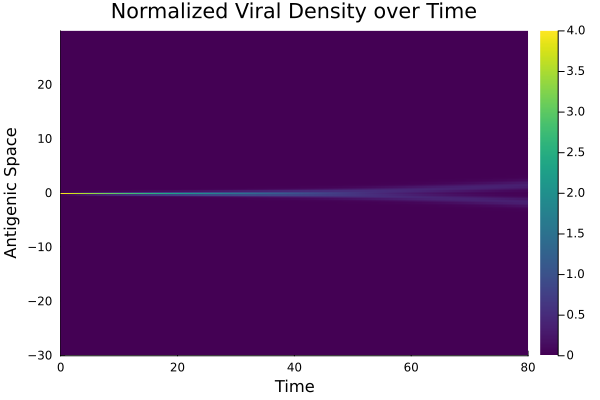

In [96]:
function plot_normalized_spacetime_density(simulation)
    # Extract relevant data
    times = simulation.duration_times # assuming this gives the array of time points
    x = simulation.trajectory[end].populations[1].xs # assuming this gives the spatial domain

    tot_infected = calculate_total_infected(simulation)
    
    z = hcat([(tot > 0 ? t.populations[1].viral_density ./ tot : zeros(size(t.populations[1].viral_density))) 
              for (t, tot) in zip(simulation.trajectory, tot_infected)]...) 
    # normalized viral densities over time or zeros if total infected is 0

    # Plotting
    heatmap(times, x, z,
        xlabel="Time",
        ylabel="Antigenic Space",
        color=:viridis, # or another color palette
        title="Normalized Viral Density over Time"
    )
end

plot_normalized_spacetime_density(simulation)


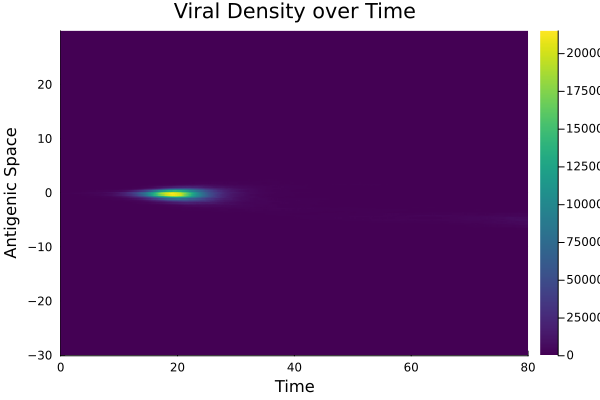

In [68]:
plot_spacetime_density(simulation)

In [107]:
function plot_spacetime_density(simulation)
    # Extract relevant data
    times = simulation.duration_times # assuming this gives the array of time points
    x = simulation.trajectory[end].populations[1].xs # assuming this gives the spatial domain
    
    z = hcat([network.populations[1].viral_density for network in simulation.trajectory]...) # viral densities over time
    
    # Plotting
    heatmap(times, x, z,
        xlabel="Time",
        ylabel="Antigenic Space",
        color=:viridis, # or another color palette
        title="Viral Density over Time"
    )
end

function plot_normalized_spacetime_density(simulation)
    # Extract relevant data
    times = simulation.duration_times # assuming this gives the array of time points
    x = simulation.trajectory[end].populations[1].xs # assuming this gives the spatial domain

    tot_infected = calculate_total_infected(simulation)
    
    z = hcat([(t.populations[1].viral_density ./ tot) for (t, tot) in zip(simulation.trajectory, tot_infected)]...) # normalized viral densities over time

    # Plotting
    heatmap(times, x, z,
        xlabel="Time",
        ylabel="Antigenic Space",
        color=:viridis, # or another color palette
        title="Normalized Viral Density over Time"
    )
end

plot_normalized_spacetime_density (generic function with 1 method)

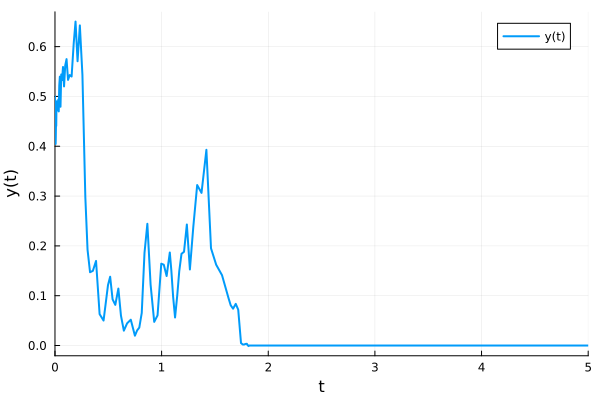

In [54]:
# Define the deterministic and stochastic parts
function f(y, p, t)
    return 0
end

function g(y, p, t)
    return sqrt(abs(y * (1 - y)))  # y is a scalar here
end

# Define a callback to set the population to zero if it drops below a threshold
function condition(y, t, integrator)
    return y < 1e-9  # Trigger the callback if y < 1e-9
end

function affect!(integrator)
    integrator.u = 0.0  # Set population to zero
end

cb = DiscreteCallback(condition, affect!)

# Initial condition, time span
y0 = 0.5
tspan = (0.0, 5.0)

# Solve the SDE
prob = SDEProblem(f, g, y0, tspan)
sol = solve(prob, callback=cb)

# Optional: Plotting the Solution
plot(sol, label="y(t)", xlabel="t", ylabel="y(t)", lw=2)
